#Redes neurais para resolução de equações diferenciais
(Código: https://github.com/Isaac-Somerville/Neural-Networks-for-Solving-Differential-Equations/tree/main?tab=readme-ov-file)

(Fonte:I. E. Lagaris, A. Likas, and D. I. Fotiadis. “Artifial neural networks for solving ordinary and
partial differential equations”. In: IEEE Transactions on Neural Networks (1998).)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
teste erro total =  176.63812255859375
MSE entre a rede e solução analítica =  73.87336730957031


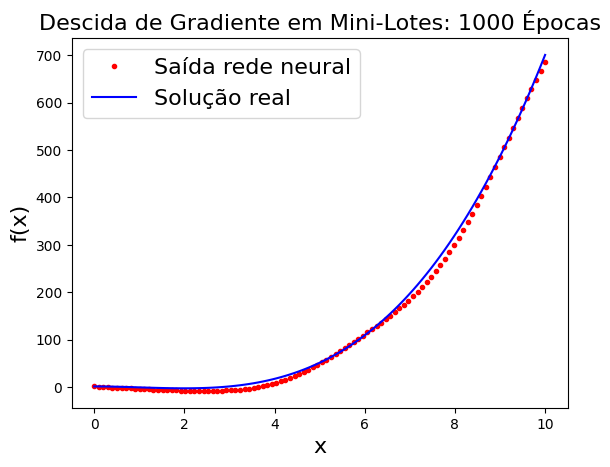

1000 épocas no total, custo final =  50.39782
tempo total decorrido =  109.22327852249146  segundos


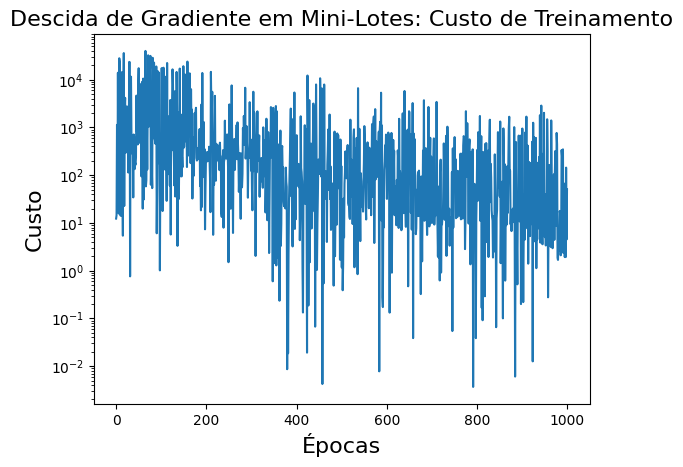

In [ ]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import grad

class DataSet(torch.utils.data.Dataset):
    """
    Um objeto para gerar valores de x
    """
    def __init__(self, numSamples, xRange):
        """
        Argumentos:
        xRange (list of length 2) -- limite inferior e superior de x
        numSamples (int) -- numero de amostras de x

        Returns:
        DataSet com um atributo:
            dataIn (PyTorch tensor of shape (numSamples,1)) -- 'numSamples'
                evenly-spaced data points from xRange[0] to xRange[1]
        """
        self.dataIn  = torch.linspace(xRange[0], xRange[1], numSamples, requires_grad=True).view(-1,1)
        # 'view' transpoe o tensor, nesse caso para um vetor coluna

    def __len__(self):
        """
        Argumentos:
        Nenhum

        Returns:
        len(self.dataIn) (int) -- numero de amostras de x
        """
        return len(self.dataIn)

    def __getitem__(self, idx):
        """
        Usado pelo objeto DataLoader para recuperar pontos de dados de treinamento

        Argumentos:
        idx (int) -- index do dado a ser recuperado

        Returns:
        x (tensor shape (1,1)) -- dado de treinamento de índice 'idx'
        """
        return self.dataIn[idx]

class Fitter(torch.nn.Module):
    """
    O objeto da rede neural, com um no de entrada,
    1 no de saida, e uma camada oculta com 'numHiddenNodes' nos
    """
    def __init__(self, numHiddenNodes):
        """
        Argumentos:
        numHiddenNodes (int) -- numero de nos da camada oculta

        Returns:
        Fitter object (neural network) com dois atributos:
        fc1 (fully connected layer) -- transformação linear da camada oculta
        fc2 (fully connected layer) -- transformação linear da camada externa
        """
        super(Fitter, self).__init__()
        self.fc1 = torch.nn.Linear(in_features = 1, out_features = numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features = numHiddenNodes, out_features = 1)

    def forward(self, x):
        """
        Função que conecta entradas a saídas na rede neural.

        Argumentos:
        x (tensor do PyTorch de forma (batchSize,1)) -- entrada da rede neural

        Retorna:
        y (tensor do PyTorch de forma (batchSize,1)) -- saída da rede neural
        """
        # tanh funcao de ativacao usada na camada oculta
        h = torch.tanh(self.fc1(x))
        # funcao de ativacao linear usada na camada externa
        y = self.fc2(h)
        return y


def plotNetwork(network, descentType, epoch):
    '''
    Plota a rede neural e solucao analitica
    '''
    x    = torch.linspace(xRange[0], xRange[1], 100, requires_grad=True).view(-1,1)
    N    = network.forward(x)
    f_trial = trialFunc(x, N)
    dndx = grad(N, x, torch.ones_like(N), retain_graph=True, create_graph=True)[0]
    df_trial = dTrialFunc(x, N, dndx)
    diff_eq = diffEq(x, f_trial, df_trial)
    cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
    print("teste erro total = ", cost.item())

    exact = solution(x)
    MSECost = lossFn(f_trial, exact)
    print("MSE entre a rede e solução analítica = ", MSECost.item())
    exact = exact.detach().numpy()
    x = x.detach().numpy()
    N = N.detach().numpy()
    plt.plot(x, trialFunc(x,N), 'r.', label = "Saída rede neural")
    plt.plot(x, exact, 'b-', label = "Solução real")

    plt.xlabel("x", fontsize = 16)
    plt.ylabel("f(x)", fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.title(descentType + " " + str(epoch) + " Épocas", fontsize = 16)
    plt.savefig('meu_grafico.svg', format="svg")
    plt.show()

def trialFunc(x, n_out):
    """
    Solução de teste para o problema 1 de Lagaris: f(x) = 1 + xN(x)
    Argumentos:
        x (tensor de forma (batchSize,1)) -- entrada da rede neural
        n_out (tensor de forma (batchSize,1)) -- saída da rede neural
    Retorna:
        1 + x * n_out (tensor de forma (batchSize,1)) -- solução de teste para a equação diferencial
    """
    return 1 + x * n_out

def dTrialFunc(x, n_out, dndx):
    """
    Derivada da solução de teste para o problema 1 de Lagaris: f'(x) = N(x) + xN'(x)
    Argumentos:
        x (tensor de forma (batchSize,1)) -- entrada da rede neural
        n_out (tensor de forma (batchSize,1)) -- saída da rede neural
        dndx (tensor de forma (batchSize,1)) -- derivada de n_out em relação a x
    Retorna:
        n_out + x * dndx (tensor de forma (batchSize,1)) -- derivada da função de teste em relação a x
    """
    return n_out + x * dndx

def diffEq(x, f_trial, df_trial):
    """
    Retorna D(x) da equação diferencial D(x) = 0 do problema 1 de Lagaris
    Argumentos:
        x (tensor de forma (batchSize,1)) -- entrada da rede neural
        f_trial (tensor de forma (batchSize,1)) -- solução de teste em x
        df_trial (tensor de forma (batchSize,1)) -- derivada da solução de teste em x
    Retorna:
        LDE - LEE (tensor de forma (batchSize,1)) -- equação diferencial avaliada em x (LDS-lado direito da equação, LES-lado esquerdo da solução)
    """
    LDE = df_trial
    LEE = 3*x**2-6*x
    return LDE - LEE

def solution(x):
    """
    Solução analítica para o problema 1 de Lagaris
    Argumentos:
        x (tensor de formato (batchSize,1)) -- entrada da rede neural
    Retorna:
        y (tensor de formato (batchSize,1)) -- solução analítica da equação diferencial em x
    """
    y =  x**3-3*x**2 +1
    return y

descentType = "Descida de Gradiente em Mini-Lotes:"

def train(network, loader, lossFn, optimiser, numEpochs):
    """
    Uma função para treinar uma rede neural para resolver uma
    EDO de primeira ordem com condições de contorno de Dirichlet.

    Argumentos:
    network (Módulo) -- a rede neural
    loader (DataLoader) -- gera lotes do conjunto de dados de treinamento
    lossFn (Função de Perda) -- função de perda da rede
    optimiser (Otimizador) -- realiza a otimização de parâmetros
    numEpochs (int) -- número de épocas de treinamento

    Retorna:
    costList (lista de comprimento 'numEpochs') -- valores de custo de todas as épocas
    """
    cost_list=[]
    network.train(True) # define o módulo no modo de treinamento
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network.forward(batch) # saída da rede

            # Obter a derivada da saída da rede em relação aos valores de entrada:
            dndx = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True)[0]
            # torch.ones_like(x) cria um tensor com o mesmo formato que x, preenchido com 1's

            # Obter o valor da solução de teste f(x)
            f_trial = trialFunc(batch, n_out)
            # Obter df / dx
            df_trial = dTrialFunc(batch, n_out, dndx)
            # Obter LHS da equação diferencial D(x) = 0
            diff_eq = diffEq(batch, f_trial, df_trial)

            cost = lossFn(diff_eq, torch.zeros_like(diff_eq)) # calcula o custo
            # torch.zeros_like(x) cria um tensor com o mesmo formato que x, preenchido com 0's
            cost.backward() # realiza retropropagação
            optimiser.step() # realiza a otimização de parâmetros
            optimiser.zero_grad() # redefina os gradientes para zero

        cost_list.append(cost.detach().numpy())# armazena o custo de cada época
    network.train(False) # define o módulo fora do modo de treinamento
    return cost_list

try: # carregar a rede salva, se possível
    checkpoint = torch.load('problem1.pth')

    network    = checkpoint['network']
except: # criar uma nova rede
    network    = Fitter(numHiddenNodes=10)
    checkpoint = {'network': network}
    torch.save(checkpoint, 'problem1.pth')

xRange       = [0, 10]
numSamples   = 100
batchSize    = 1
paramUpdates = 20000
train_set    = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)
lossFn       = torch.nn.MSELoss()
optimiser    = torch.optim.SGD(network.parameters(), lr=5e-6
                               )


costList = []
epoch = 0
numEpochs = 50
totalEpochs = 1000
start = time.time()
while epoch < totalEpochs:
    costList.extend(train(network, train_loader, lossFn, optimiser, numEpochs))
    epoch += numEpochs
    print(epoch) # imprime o número da época atual
end = time.time()


plotNetwork(network, descentType, epoch)
print(epoch, "épocas no total, custo final = ", costList[-1]) # imprime o número total de épocas e o custo final
print("tempo total decorrido = ", end - start, " segundos") # imprime o tempo total decorrido

plt.semilogy(costList)
plt.xlabel("Épocas",fontsize = 16)
plt.ylabel("Custo",fontsize = 16)
plt.title(descentType + " Custo de Treinamento",fontsize = 16)

x    = torch.linspace(xRange[0], xRange[1], 100, requires_grad=True).view(-1,1)
N    = network.forward(x)